In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../data_segments/data_balanced_duplicate_sample/"
sz=256
arch=resnet50

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['train', 'valid', 'tmp', 'models']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C13-67_03_3500_6000_2.jpg',
 'C10-51_01_2997_8325_2.jpg',
 'C04-17_05_4662_5661_0.jpg',
 'C10-51_02_3500_1500_3.jpg',
 'C10-51_02_7000_7000_1.jpg']

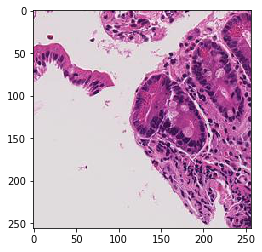

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[0]}')
plt.imshow(img);

In [9]:
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(0.001, 2)

## Visualising Results

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Normal')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
y = data.val_y

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

## Data Augmentation

In [10]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

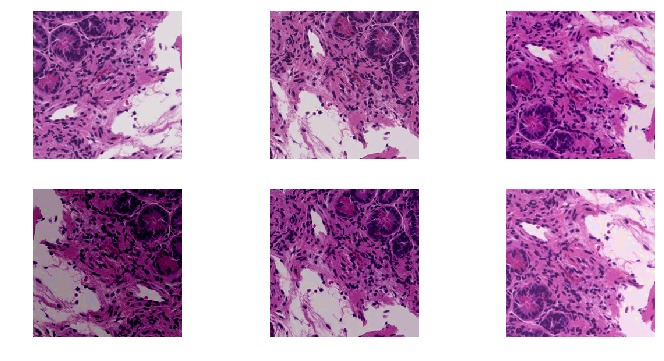

In [13]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [14]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(1e-3, 3, cycle_len=1)

In [ ]:
learn.save('256_lastlayer_resnet50_duplicates_transformations')

In [ ]:
learn.load('256_lastlayer_resnet50_duplicates_transformations')

## Unfreezing layers and using Differential learning rates

In [18]:
# Unfreeze all layers for training
learn.unfreeze()

In [123]:
lrf=learn.lr_find()

 80%|████████  | 5920/7372 [52:34<12:28,  1.94it/s, loss=0.787]  

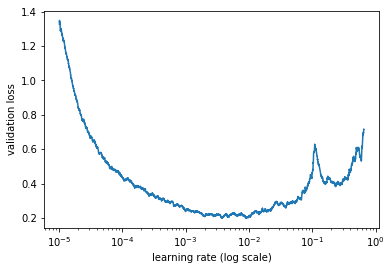

In [124]:
learn.sched.plot()

In [19]:
lr = (1e-4 + 1e-3)/2

In [20]:
lr=np.array([lr/9,lr/3,lr])

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.232195   0.211999   0.906209  
    1      0.164571   0.187507   0.918666                        
    2      0.139496   0.187045   0.919866                        
    3      0.116324   0.179156   0.928661                         
    4      0.085567   0.171354   0.933175                         
    5      0.076122   0.176361   0.934469                         
    6      0.068809   0.185926   0.931129                         


[0.18592591512677695, 0.9311294070108092]

In [22]:
learn.save('256_all_resnet50_duplicates_transformations')
learn.load('256_all_resnet50_duplicates_transformations')

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [23]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9408210425295485

In [24]:
log_preds.shape

(5, 158384, 3)

In [25]:
log_preds_mean = np.mean(log_preds, 0)

In [26]:
np.save('../data_segments/logpreds_resnet50_all_layers256x256_duplicates_TTA_HSV_contrast.npy', log_preds)

In [27]:
preds = np.argmax(probs, axis=1)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[55174     0  3762]
 [    0 51784     0]
 [ 5611     0 42053]]


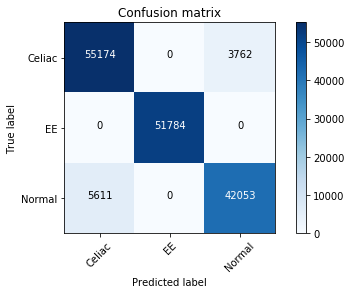

In [29]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

Most Correct Celiac


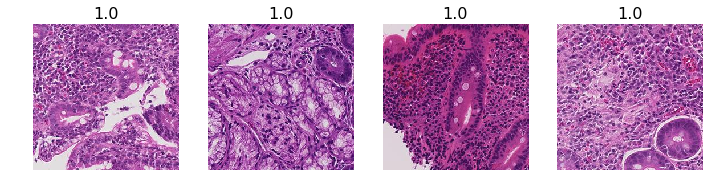

In [30]:
imr = ImageModelResults(data.val_ds, log_preds_mean)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


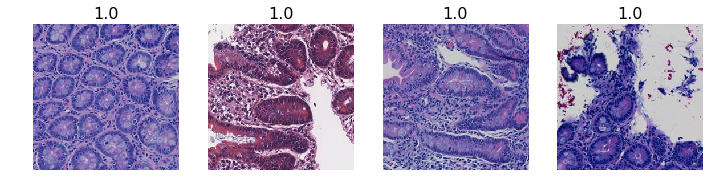

In [31]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Noraml


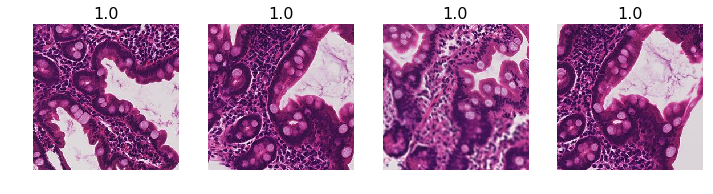

In [32]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

Most Incorrect Celiac


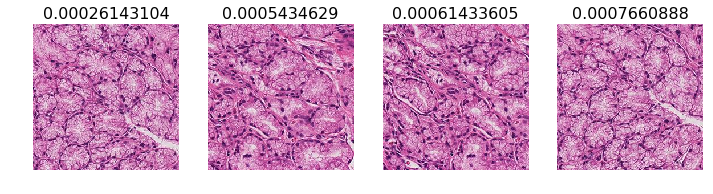

In [33]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [34]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect EE


False

Most Incorrect Normal


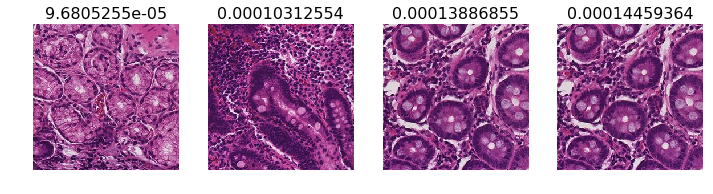

In [35]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

Most Uncertain Celiac


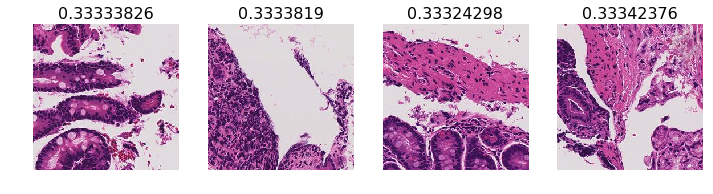

In [36]:
print('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

Most Uncertain EE


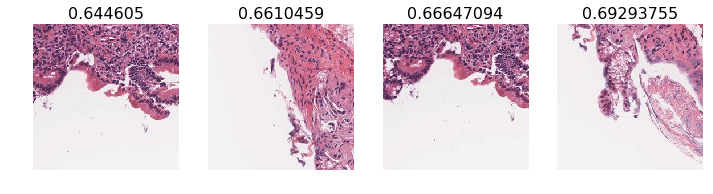

In [37]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

Most Uncertain Normal


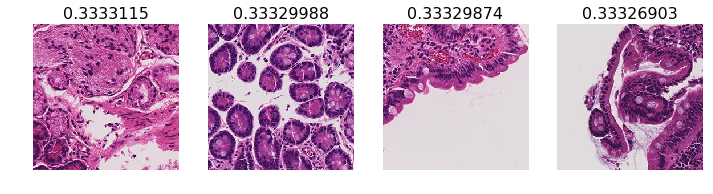

In [38]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [39]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [40]:
preds = np.argmax(log_preds, axis=1)

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[54272     0  4664]
 [    1 51783     0]
 [ 6243     0 41421]]


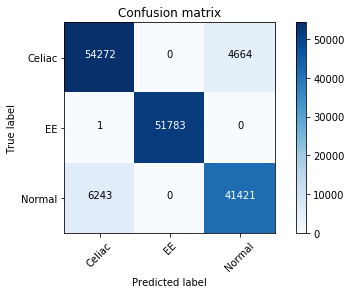

In [42]:
plot_confusion_matrix(cm, data.classes)

## Saving predictions of the model with TTA

In [43]:
res = pd.DataFrame(np.exp(log_preds_mean))

In [44]:
res['file'] = data.val_ds.fnames

In [45]:
res.columns = ['Celiac', 'EE', 'Normal', 'FileName']

In [46]:
res.to_csv('../results/preds_resnet50_256_duplicates_TTA.csv')

In [47]:
res.head()

,Celiac,EE,Normal,FileName
0,0.128231,0.000032,0.781028,valid/Celiac/C13-67_03_3500_6000_2.jpg
1,0.986703,0.000014,0.010806,valid/Celiac/C10-51_01_2997_8325_2.jpg
2,0.999295,0.000016,0.000418,valid/Celiac/C04-17_05_4662_5661_0.jpg
3,0.856217,0.000016,0.042832,valid/Celiac/C10-51_02_3500_1500_3.jpg
4,0.996682,0.000094,0.001996,valid/Celiac/C10-51_02_7000_7000_1.jpg


In [48]:
res.to_csv('../results/preds_resnet50_256_duplicates_TTA_HSV_contrast.csv')